In [1]:
""" Attempting higher than 0.3.
    Mixing copy_kaggle.ipynb + some more features:
        - Add more filters
        - batch_size set to 4
        - use dropout
        - change activation to e_swish
        - Introduce dice_coeff
"""

import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import u_net as unet
from keras import backend as K
import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128*2
IMG_HEIGHT = 128*2
IMG_CHANNELS = 3
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
for n, id_ in enumerate(train_ids):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask
    
    if (n+2)%67 == 0: print((n+2)//67*10, "%")

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
Getting and resizing test images ... 
Done!


c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


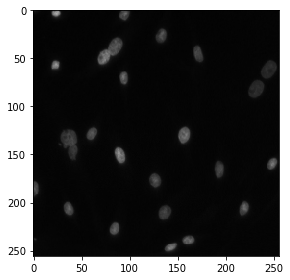

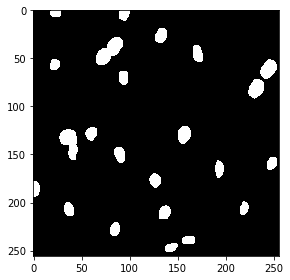

In [4]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [ ]:
def e_swish(x):
    return 1.375*x*K.sigmoid(x)

model = unet.u_net(start=32, act=e_swish, starter="glorot", dropout=None)
loss = unet.bce_dice_loss
metrics = [unet.mean_iou, unet.dice_coef]
model.compile(optimizer='adam', loss=loss, metrics=metrics)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [10]:
# Fit model
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=50)

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 105s 175ms/step - loss: -0.2165 - mean_iou: 0.4851 - dice_coef: 0.4602 - val_loss: -0.5236 - val_mean_iou: 0.5875 - val_dice_coef: 0.6340
Epoch 2/50
603/603 [==============================] - 101s 167ms/step - loss: -0.6273 - mean_iou: 0.6368 - dice_coef: 0.7401 - val_loss: -0.6239 - val_mean_iou: 0.6747 - val_dice_coef: 0.7336
Epoch 3/50
603/603 [==============================] - 101s 167ms/step - loss: -0.6743 - mean_iou: 0.6937 - dice_coef: 0.7737 - val_loss: -0.7345 - val_mean_iou: 0.7146 - val_dice_coef: 0.8120
Epoch 4/50
603/603 [==============================] - 101s 168ms/step - loss: -0.7359 - mean_iou: 0.7306 - dice_coef: 0.8172 - val_loss: -0.7264 - val_mean_iou: 0.7414 - val_dice_coef: 0.8035
Epoch 5/50
603/603 [==============================] - 101s 167ms/step - loss: -0.7582 - mean_iou: 0.7498 - dice_coef: 0.8317 - val_loss: -0.7676 - val_mean_iou: 0.7600 - val_dice_coef: 0.

603/603 [==============================] - 100s 166ms/step - loss: -0.8491 - mean_iou: 0.8587 - dice_coef: 0.8946 - val_loss: -0.8200 - val_mean_iou: 0.8591 - val_dice_coef: 0.8712
Epoch 44/50
603/603 [==============================] - 100s 166ms/step - loss: -0.8506 - mean_iou: 0.8596 - dice_coef: 0.8962 - val_loss: -0.8211 - val_mean_iou: 0.8599 - val_dice_coef: 0.8701
Epoch 45/50
603/603 [==============================] - 100s 167ms/step - loss: -0.8498 - mean_iou: 0.8603 - dice_coef: 0.8960 - val_loss: -0.8124 - val_mean_iou: 0.8607 - val_dice_coef: 0.8662
Epoch 46/50
603/603 [==============================] - 100s 166ms/step - loss: -0.8312 - mean_iou: 0.8610 - dice_coef: 0.8835 - val_loss: -0.8115 - val_mean_iou: 0.8612 - val_dice_coef: 0.8669
Epoch 47/50
603/603 [==============================] - 100s 166ms/step - loss: -0.8491 - mean_iou: 0.8616 - dice_coef: 0.8947 - val_loss: -0.8214 - val_mean_iou: 0.8619 - val_dice_coef: 0.8725
Epoch 48/50
603/603 [==========================

In [11]:
# Predict on train, val and test
# model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 2s 32ms/step


c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


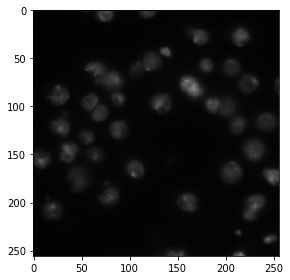

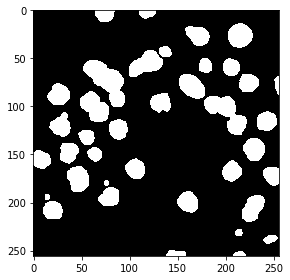

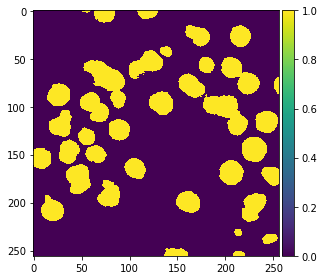

In [12]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


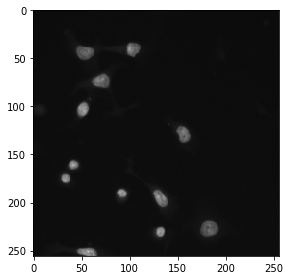

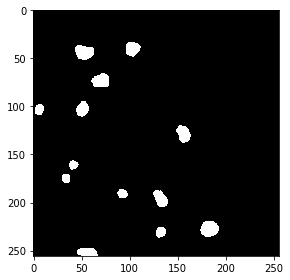

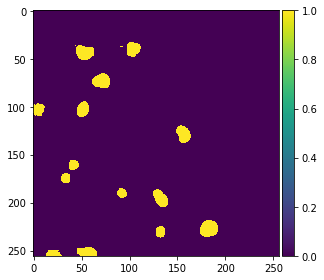

In [13]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [14]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [15]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [16]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub.csv', index=False)